# Scientific Computing - EMAT30008 -  Report

This report will outline the code produced for this module as a library able to compute limit cycles of ODE's and PDE's as well as calculating the steady-state solutions of diffusive PDE's

# 1. Brief Summary of the Code

In [2]:
# imports 
import numpy as np
import matplotlib.pyplot as plt
from helpers import *
from test_equations import *

### ODE solvers
 - `solve_to` and solvers.py (`euler_step`, `rk4_step` and `heun_step`): 
 
These methods are used as the building blocks for all the other integration code. The solvers (solvers.py) that I have implemented are single step integrators using Euler, Runge-Kutta and Heun methods. These methods provide different accuracies (with Heun and RK4 being much more accurate than Euler). The functions are incorporated in the solve_to method which allows the integration of a function between 2 times. The functions take any number of dimensions as long as the function is provided in a first order form, with args. As these form the building blocks of much of the code in this module, there are input checks to ensure that the correct data types are being fed into these functions by higher level code, and therefore making errors more traceable. 

### Discretisation using shooting methods
 - `Discretisation`, `shooting_setup` and `shooting_solve`
 
These methods are made in such a way that the Discretisation class will provide a discretisation of a given problem (either using a shooting method or a linear [none] method (*)). This class is made so that adding other discretisations is simple and the outputs and inputs are always the same. This is build on using the continuation class. The shooting code will, given a relatively close guess, find the starting conditions for a limit cycle and provide the period of the limit cycle for a given ode and parameters. 

*The linear method allows direct solution of an input equation and should be used with algebraic equations.

### Continuation
- `Continuation`, `nat_continuation` and `ps_arc_continuation`

The discretisation using shooting, or linear method, are then used by the `Continuation` class. The continuation class contains the natural continuation method where for any given equation, starting point and parameters, the method aims to find the root of the discretised problem (whether its a root of an equation or a shooting problem identifying the limit cycle) at each parameter value and then incrementing the parameter to follow the solution. The pseudo-arclength method is also implemented in the continuation class. This method is similar to the natural method but uses the tangent to the solution to find the next point. This method is more robust and can be used to find bifurcations. The plot below shows the natural and arclength continuation methods for the hopf bifurcation.

Both the continuation methods take as input: function, x0, starting param, vary param (idx), step, max_steps, discretisation type. The discretisation class, used to make the function F(u) = 0 for root finding, is modular and so can be built on in the future to include other methods such as collocation.

The psuedo arclength method should be more robust, however in my current implementation there is a mistake in the tangent calculation. This is something I will fix in the future - it is shown here because the framework is in place and the method is implemented, however I need to find the bug in the tangent calculation.

/Users/philblecher/Desktop/Github/ScientificComputing-EMAT30008/test_equations.py:86: RuntimeWarning: overflow encountered in scalar power
  drdt = b*r + r**3 - r**5
/Users/philblecher/Desktop/Github/ScientificComputing-EMAT30008/test_equations.py:86: RuntimeWarning: invalid value encountered in scalar subtract
  drdt = b*r + r**3 - r**5


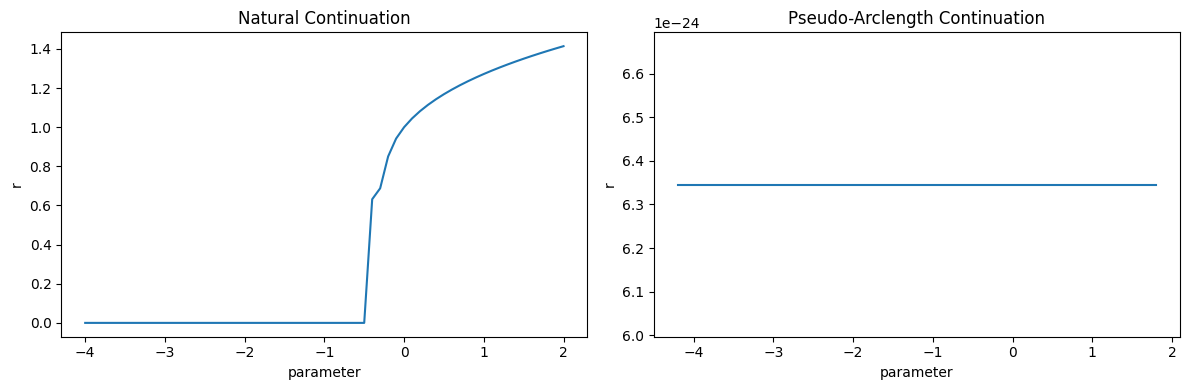

In [15]:
from continuation import Continuation as cont
from shooting import Discretisation as discret
# using the polar form of the lokta-volterra equations
# define the initial conditions and parameter
x0 = [1, 1]
p0 = 2
# natural continuation with no discretisation
X_nat, C_nat = cont().nat_continuation(polar, x0, p0, vary_p = 0, step = -0.1, max_steps = 60, discret=discret().shooting_setup)
# extract the r value (the first element of the solution)
R_nat = [x[0] for x in X_nat] 

# pseudo arc continuation with shooting discretisation
X_arc, C_arc = cont().ps_arc_continuation(polar, x0, p0, vary_p = 0, step = -0.1, max_steps = 60, discret=discret().shooting_setup)
# extract the r value (the first element of the solution)
R_arc = [x[0] for x in X_arc] 

# plot the results on two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(C_nat, R_nat)
ax1.set_xlabel('parameter')
ax1.set_ylabel('r')
ax1.set_title('Natural Continuation')
ax2.plot(C_arc, R_arc)
ax2.set_xlabel('parameter')
ax2.set_ylabel('r')
ax2.set_title('Pseudo-Arclength Continuation')
plt.tight_layout()
plt.show()

### BVP solvers 
- `ODE`, `Solver` and `solve`

The bvp_solver contains the ODE class and the Solver class. The ODE class stores all the coefficients, boundary conditions, functions and arguments associated with an ODE equation in 2nd order form. The Solver class allows the equation, number of interior points and the solving method to be specified and the problem initialised. The solver then solves problem, giving the solution values u = solver.solve(). The solver object stores the solutions u and the grid x. These modules allow for a source term to be included (as a function of x,u and args). The bvp_solver Solver class has implemented scipy `root`, numpy `linalg.solve` and a custom `tdma` (Thomas algorithm) methods. Only scipy root is able to deal with non-linear source terms. The plot below shows the solution to an ODE with a non-linear source term.

The coefficients of the equation are in the form:
mx'' + cx' + kx = q(x,u,args) These are all stored by the ODE class, which is accessed through the Solver class.

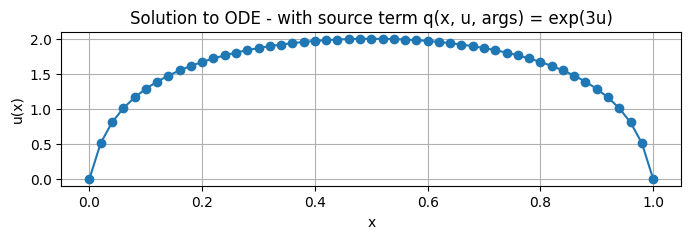

In [9]:
# define the BVP ODE to solve
m, c, k,  bound_type, alpha, beta, a, b, args = 1, 1, 1, 'DD', 0, 0, 0, 1, (3,)
q = lambda x, u, *args: np.exp(args[0] * u) # lambda function for q(x, u, args)

# create the ODE object
from bvp_solver import ODE
ode = ODE(m, c, k, q, bound_type, alpha, beta, a, b, *args)
# create the solver object
from bvp_solver import Solver
N , method = 50, 'scipy'
solver = Solver(ode, N, method)
# solve the ODE
u = solver.solve()
x = solver.x

plt.figure(figsize=(8,2))
# plot the solution
plt.plot(x, u, 'o-')
plot_help(plt, 'x', 'u(x)', 'Solution to ODE - with source term q(x, u, args) = exp(3u)')


### PDE solvers
- `PDE`, `Solver` and `solve`

The pde_solver module functions in the same way as the bvp_solver module. The PDE object contains the coefficients, boundary conditions, functions (starting condition and source term) and arguments associated with an PDE equation in 2nd order form. The main difference is that there are different methods allowed to be specified in the Solver class and that the source function can be non-linear and a function q(x, t, u, args) and the starting condition can be a function f(x, args).

The solving methods implemented in the solver class are: the one step integrators (Euler, RK4, Heun) in explicit form, implicit Euler, Crank-Nicolson, solve_ivp and implicit-explicit Euler. The Crank-Nicolson method has the option for use of sparse matrix calculation. Of the methods, solve_ivp, imex and the custom methods allow for non-linear in time source terms. The code below demonstrates two methods for two different PDEs.

In [3]:
# demo of some of the PDE solvers - two examples
from pde_solver import PDE, Solver

# make the PDE object
f, m, q, bound_type, alpha, beta, a, b, args = lambda x: np.sin((np.pi*(x-a)/b-a)),1,1,'DD', 0, 0, 0, 1, (3,) # linear source term
pde = PDE(f, m, q, bound_type, alpha, beta, a, b, *args)
q = lambda x, t, u, *args: 2*u # lambda function for q(x, u, args) - non linear source term
hard_pde = PDE(f, m, q, bound_type, alpha, beta, a, b, *args)

# create the solver object with a variety of methods
solver = Solver(pde, N=20, t_final=1, method='solve_ivp')
u = solver.solve()
x = solver.x
t = solver.t
# solve the second more complicated PDE using homemade RK4
hard_solver = Solver(hard_pde, N=100, t_final=1, method='RK4', CFL=0.1) 
hu = hard_solver.solve()
hx = hard_solver.x
ht = np.append(hard_solver.t, hard_solver.t_final)

Text(0.5, 0.92, 'Solution to PDE - q(x, t, u) = 2*u - RK4')

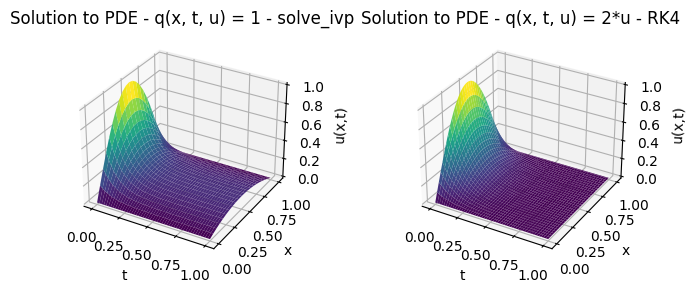

In [4]:
# plot the solution as a surface
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(121, projection='3d', xlabel='t', ylabel='x', zlabel='u(x,t)')
T, X = np.meshgrid(t, x)
surf = ax.plot_surface(T, X, u, cmap='viridis')
ax.set_title('Solution to PDE - q(x, t, u) = 1 - solve_ivp')
ax2 = fig.add_subplot(122, projection='3d', xlabel='t', ylabel='x', zlabel='u(x,t)')
hT, hX = np.meshgrid(ht, hx)
hsurf = ax2.plot_surface(hT, hX, hu, cmap='viridis')
ax2.set_title('Solution to PDE - q(x, t, u) = 2*u - RK4')

For the RK4 (and other homemade methods) the CFL value must be very low to allow a good solution. 

### Profiling Solvers
- `profile`

The pde_solver module has a profile function defined that tests all the solvers on a set PDE for a set number of gridpoints and final time. The default values are taken for the other parameters to ensure a fair comparison. This profiler uses cProfile and pstats modules to test and record the total time taken by each method. The results are plotted below: 

In [12]:
# profiling of the solvers (for the simple pde)
from pde_solver import profile
stats, methods = profile(pde, N=50, t_final=1) # define the number of points and the final time

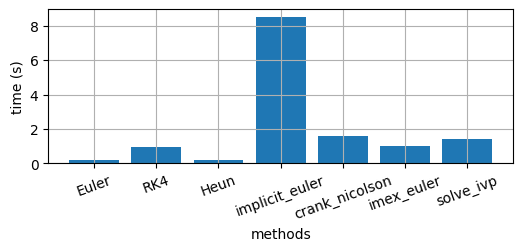

In [13]:
# for each stats object, extract the total time and plot as a bar chart
total_tt = []
num_calls = []
for i, method in enumerate(methods):
    total_tt.append(stats[i].get_stats_profile().total_tt)

plt.figure(figsize=(6,2))
plt.bar(methods, total_tt)
plt.xticks(rotation=20)
plot_help(plt, 'methods', 'time (s)')

Looking at the breakdown of the implicit euler method shows that cumuluatively the F_solve and its subfunction F take the most time. These functions are used to wrap the problem in such a way that scipy's root can be used to solve the nonlinear system for u. This would be the start point for improving the implicit solver.

### Sparse Matrices

The option for using sparse matrices has been introduced for the Crank-Nicolson method. This is possible for more methods but has not been implemented yet. The main benefits of the sparse A matrix is the reduction in memory usage. The figure below shows the performance improvements for the Crank-Nicolson method when adding the option of using sparse matrix forms. There is no consistent time improvements for the range of grid points tested, however, the memory saving for the A matrix is significant. This is because the A matrix is a tridiagonal matrix and so can be stored in a sparse form. 

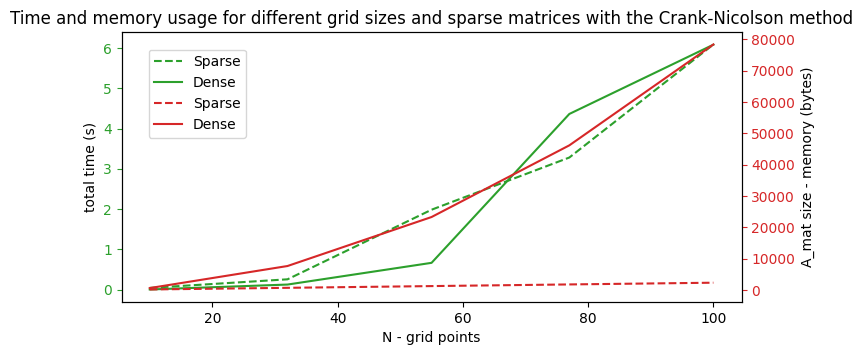

In [14]:
from helpers import help_prof
# one axis for time, one for memory on the same plot and corresponding colours
fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
ax2 = ax.twinx()
for i,sparse in enumerate([True, False]):
    total_t = []
    stor = []
    n_range = np.linspace(10, 100, 5, dtype=int)
    for n in n_range:
        stats, nbytes = help_prof(n, sparse, Solver, pde) # help_prof profiles the solver, returns stats and memory usage
        total_t.append(stats.get_stats_profile().total_tt)
        stor.append(nbytes)

    # plot the time and memory usage for sparse and dense matrices: time is green, memory is red, sparse is dashed lines
    ax.plot(n_range, total_t, color='C2', label='Sparse' if sparse else 'Dense', linestyle= '--' if sparse else '-')
    ax2.plot(n_range, stor, color='C3', label='Sparse' if sparse else 'Dense', linestyle= '--' if sparse else '-')

    
ax.set_xlabel('N - grid points')
ax.set_ylabel('total time (s)')
ax2.set_ylabel('A_mat size - memory (bytes)')
ax.tick_params(axis='y', colors='C2')
ax2.tick_params(axis='y', colors='C3')
fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.85))
plt.title('Time and memory usage for different grid sizes and sparse matrices with the Crank-Nicolson method')
plt.show()

# 2. Key Software Design Decisions

The code is structured so that more complicated functions can call on the simpler, building block methods, allowing the user to choose between any of them as they are all defined to have the same inputs and outputs at each level. This is best shown through a heirarchy of calls, separately for the continuation, BVP's and PDE's.

#### Continuation
**Structure:**

Continuation Class:
- Pseudo-ArcLength or Natural: (calls a discretisation method for root finding) (pseudo calls natural twice)
ps_arc_continuation and nat_continuation
    - Shooting (for ODEs)
        - shooting_setup (calls the solve_to function)
            - solve_to integrates the ODE to a given point (calls the integration method)
                - solvers (calls the one step integration method)
                    - Euler
                    - RK4
                    - Heun

        - Solver to find the root of the shooting problem (calls the root finding method) F(u) = 0
            - scipy root
            - numpy linalg.solve

    - Linear (for algebraic equations)
        - f(x) -> F(x) = 0 (calls the root solver method)
            - scipy root
            - numpy linalg.solve

Each point in the hierarchy allows a choice of at least two options. The structure of the code allows for easy inclusion of new methods and new problems because the inputs and outputs are pre-defined at each boundary. Additionally, this means that the lower level code is called by the higher level code, reducing repetition, and allowing testing of most called functions.

**Design Decisions:**

In order of development, the one step integration methods were developed first. As these form the building blocks of the higher level methods, they were developed to be robust to any number of dimensions and parameters. With the inputs and the output clearly defined, these methods were tested to ensure robustness to all possible uses. 

The one step integration methods are called by the `solve_to` method, simply repeating the integration method until the solution is at the desired point. The main design decision was ensuring that the final point was reached exactly. This was achieved by using a different sized final step to ensure the solution is exact. An error check function is used for the `solve_to` to ensure incorrect inputs are identified.

The shooting method uses the `solve_to` method to 'shoot' to a solution for a given starting point, parameters and period. These values are adjusted by a solver until all the conditions for a limit cycle are met: the start and end values for each variable are equal, and the derivative at the start of the solution for the first variable is equal to zero. Originally the shooting method was created as a single function, however, this was split into two functions to allow for the shooting setup to be called by the continuation methods. The shooting setup function takes the initial guess for the solution and the starting parameters (An arbitrary intial estimate of period is used) and returns the function to be solved by the root finding method in continuation, in the form F(u) = 0. This function can then be solved by scipy's `root` or numpy's `linalg.solve`. 

By having the `shooting_setup` function separate to the solver, the natural continuation method (and in future pseudo-arclength continuation) can call the `shooting_setup` function to get the function to be solved. 

The linear method is a simple wrapper for the root finding method. The function to be solved is simply the input function, F(x) = 0. This is then solved by the root finding method as a standard 1 dimensional problem.

The continuation methods are then called by the continuation class. The continuation class takes the problem, the discretisation method, the root finding method, the step size, the maximum number of steps, the starting point and the starting parameter. The inputs have been decided on to ensure that new continuation methods (prior to pseudo-arclength) could be easily added. The starting point and starting parameter are used to define the initial guess for the solution. In addition, on creating of the class the solver and discretisation methods are defined. This allows the user to choose between the different methods available, as all the modules are designed to have the same inputs and outputs. With more time, the pseudo-arclength continuation method would call a shooting method to get the function to be solved, and then solve this using the root finding method.

#### BVP's

**Structure:**

bvp_solver module
- BVP class:
    Creates the problem equation and stores the boundary conditions, allows the same form to be used for all methods
- Solver class:
    Takes the problem, number of interior points and the solving method. The solution is then stored in the solver object and can be accessed using solver.solve(). The class also creates the A matrix and the b vector for the problem. The solving method is then called to solve the system of equations.
    - boundary (from helpers.py):
        Creates the boundary conditions for the problem using the boundary conditions defined in the BVP class and the boundary type.
    - solve():
        Uses the solving method to solve the system of equations made from the A matrix and b vector.

        Calls the solving method
        - scipy root
        - numpy linalg.solve
        - tdma
            The Thomas algorithm is used to solve the tridiagonal matrix system of equations. This is a simple method which is fast and efficient. It is implemented separately in the bvp_solver module to allow for easy inclusion of other methods.

        
**Design Decisions:**

In order of development of this problem, a function to create the boundary condition (Dirichlet Dirchlet) matrices A and b was created first. The solvers were then called and the output returned. As the complexity of the problem increased with the introduction of non-linear source terms, the creation of a source term for the problem was added, allowing for the source vector to be a function of the solution. Due to this non-linearity, only `linalg.solve` could be used to solve the system of equations. To ensure that this does not lead to any problems, a check is made to ensure that the source term is linear for the other methods.

The boundary conditions are created using the `boundary` function in helpers.py. This function takes the boundary conditions defined in the BVP class and the boundary type and returns the boundary conditions in the form of a matrix A and a vector b. This allows for the boundary conditions to be created on definition of the ODE. 

The solver class is then created to allow for the problem to be solved. The solver class takes the problem, number of interior points and the solving method. The solution is then calculated using `solver.solve()` which calls the chosen method. The solutions are stored in the solver object and can be accessed with e.g. solver.u. All features of the equation and solution are stored in the solver object, allowing for easy access to the solution and the problem.

The boundary function has the ability to create sparse matrices and so the implementation of sparse solving in bvp_solver would simply require the option for a sparse solver to be used (`sp.linalg.solve`).

#### PDE's

**Structure:**

pde_solver module
- PDE class:
    Creates the problem equation and stores the boundary conditions, allows the same form to be used for all methods
- Solver class:
    Same format as the BVP solver class but with different methods
    - boundary (from helpers.py):
        Creates the boundary conditions for the problem using the boundary conditions defined in the PDE class and the boundary type.
    - solve():
        Uses the solving method to solve the system of equations made from the A matrix and b vector.

        Calls the solving method
        - solve_ivp  - scipy
        - implicit_euler
            The implicit euler method uses scipy's root to solve an implicit system of equations.
        - crank_nicolson
            uses linalg.solve to solve the system of equations, and has the option to use a sparse solver
        - imex_euler
            Uses explicit euler to solve for non linear terms and implicit euler to solve for linear terms
        - explicit solvers from solvers.py - implemented in a loop of time steps
            - Euler
            - RK4
            - Heun

**Design Decisions:**

The PDE solver is structured in the same way as the BVP solver. The PDE class is used to create the problem equation and the Solver class is used to solve the problem. The boundary conditions are created using the boundary function in helpers.py. 

The key differences in the design of the pde module vs the bvp module is the introduction of time inputs to the PDE class and a starting condition function. These features are stored in the PDE class, which takes the same form as the BVP class but with slightly different parameters. The solver class loops over the time points (apart from `solve_ivp` as this is integrated) to calculate the solution at each time step either explicitly using the previous step, or implicitly as a system of equations.

The structure of the module allows for the input of any problem equation and the solution of this equation using any of the methods available. The solver class stores the solution and the problem equation, allowing for easy access to the solution and the problem as with the bvp solver class.

### Code Testing

The are input checkers for the most commonly called functions: solvers (`euler_step`, `rk4_step`, `heun_step`) and `solve_to` to allow errors to be traced back to the source and to check their use in the hgiher level functions. Additionally, unit tests have been developed for the solvers, shooting and continuation functions. These tests check the output of the functions against known solutions for a range of problems. The tests are run using pytest and can be found in the tests folder. The tests are automated using github actions and can be found in the actions tab of the github repository. The automation of the tests allows for the code to be tested on every push to the repository, ensuring that the code is always working as expected and no new changes cause any problems.

### Code Documentation

Each function has a docstring which describes the purpose of the function, the inputs, outputs and example implementation. This allows for the code to be easily understood. With the inputs and outputs being defined, implementation of the code can be checked by the user.

### Further Work and Alternative Approaches

There are many different approaches to the more high level problems such as continuation, bvp solvers and pde solvers. The bvp and pde solvers have a large commonality and so the next steps in terms of development would be to create a parent class common to both. Additionally the first order form used for shooting, continuation and integrators could be used as part of a single ODE object. This would allow for the ODE to be solved using any of the methods available. 

Key features which could be added to the code are:
- Bug fix to pseudo-arclength continuation
- Modular arc-length shooting function that forms the F(u) = 0 with the arc-length continuation method built in
- A parent class for all ODE/PDE problems

Additionally, the unit tests should have been expanded to cover all the inputs of all functions. This would allow for the code to be tested more thoroughly and for the user to be able to check their inputs.




# 3. Learning Log

From the Open University reflective thinking can be described as
    thinking with a purpose
    being critical, but not negative
    analysing how effective your learning is
    questioning and probing
    making judgements and drawing conclusions.
    Key questions you should try to answer in your learning log are as follows.
    What did I learn about the mathematical algorithms? I.e., solving boundary value problems, numerical ill-conditioning, etc.
    What did I learn about software engineering? How have I progressed in my abilities?
    What are the short-term implications of what I've learnt? (When will it be useful?)
    What are the long-term implications of what I've learnt? (When will it be useful?)
    What would I have done differently if I started the unit over again?
    What will I do differently in the future?
    You will probably find it helpful to make notes on the answers to these questions each week.

### Algorithms

The mathematical algorithms that I have learnt about are shooting, continuation, and numerically solving ODE's and PDE's. Although prior to this module I had an understanding of ODE's and PDE's, I had never implemented them numerically or looked at the difference between steady state and diffusive problems. As a result, this module has taught me about the concepts of limit cycles and how to calculate them numerically. I think that a prior understanding of limit cycles would have aided the code development as I feel that a large proportion of my time was spent trying to understand what the output of the code should be. This is the same for continuation, as the outputs first appeared highly abstract and it took a long time for me to understand how to formulate the problem.

As a result, I think that I now have a rough understanding of the mathematical concepts, but my understanding of the software principles that have been required is much greater. Due to the complexity of the problems, I have had to ensure that my code is well documented and structured so that I can follow it best. 

I have found the PDE and BVP sections of the module to be less challenging as I understood what the output should be and how to implement the code. I think that this is due to the fact that I had completed a similar module, wherein I had to derive the stepping formulas for the ODE's and PDE's. 

### Software Engineering

I started by writing plain scripts with small functions to make sure I got a minimum working script, once that worked I went back and re wrote all the files to contain a handful of functions needed to solve the relevant problems. This allowed me to make sure the code worked before adding the complexity of classes and methods. Eventually I went back through the code and added classes to the large problems in order to make them very modular and allow easier addition of new methods and problems.

Adding classes was simple once the code was working as the functions that existed could be moved into parts of a class. I found that once I made the classes, adding more code to each class became much simpler, as all the definitions: inputs and outputs were already defined. This sped up the development process towards the end of the module.

Additionally, I found that by using github actions, I was able to test the code every time I pushed to the repository. This allowed me to catch errors early and fix them due to the quick notifications I received from github. However, I found that had I implemented more tests throughout the module, development and tracking errors in new code would have been easier. Fortunately, the tests implemented ensured that input errors in the most low level functions would be flagged which made debugging higher level functions a lot easier.

Overall, I found that putting in the hard work of modularising the code early on allowed for the code to be easily developed and new methods and problems to be added easily afterwards. I know that in future software development projects I will aim to outline the inputs and outputs to all the problems I face, in a modular fashion (like classes), prior to writing the code. I also will aim to implement tests as I go, for the duration of a project, as this will allow for errors to be caught early and fixed quickly everytime I attempt to add new code.

### Short and Long Term Implications

Short-term, this project ran alongside my dissertation in which I was developing a mathematical model of a hydropower turbine. What I learnt through this module - namely good practice for developement and modularity - transferred into making that model highly modular and parametric with clear inputs and outputs. That code is highly parametric and modular, and as a result, was easy to conduct sensitivity analysis on. Additionally, I've gained a greater understanding of github actions, continuous integration and testing. Having the skills to set this up would not have been possible without this unit as I did not know this existed.

Long-term, the benefits of what I learnt are very similar. I will be able to develop code in a modular fashion and test it as I go. In the future I aim to work in software development to some extent, therefore having such a clear understanding of good coding practices will be critical. Additionally, the use of existing packages has allowed me to better understand how to use external tools to my advantage during the development and testing of my own projects. Having used many of the modules prior to this project, I thought that I had a good understanding of how to use them. However, through this project I have learnt how to correctly use the documentation and structure of existing modules to both implement them and to structure my code in a similar way.

### What Would I Have Done Differently / Will Do Differently?

If I started the unit again, I would have started by writing clear plans for each function, thereby allowing inputs, outputs and methods to be clearly defined prior to coding. I did this towards the end of the unit, however, I believe it would have saved a large amount of time if I had done this from the start. Specifically for the shooting and continuation methods, I would have explored examples in more detail prior to coding. I found that I had to spend a lot of time trying to understand the output of the code, which slowed down the development process.

Additionally, I think it would be beneficial to the coding process, had I implemeted each new feature for a very basic example. In the future, I would therefore try to define a list of simple problems and solutions for each feature of programming that I wish to implement. This would allow every new feature to be tested - this is test-driven development. I think that test driven development would have ensured that I understood the purpose of each function that I was implementing. This is something I struggled with during the unit, as for many of the features I was unsure of the inputs and outputs until I had written the code.

The final thing that would have benefitted me in this module would have been to create a hierarchical / block diagram of the relationships between the various methods implemented prior to development. This would have allowed the creation of common parent classes and therefore more modularity between the various methods. In hindsight, I think it would have been good to integrate the continuation, bvps and pdes under a common parent class, as they are differential equations in either steady state or diffusive form. 

